In [1]:
import pathlib
from typing import Tuple

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from deepsysid.pipeline.data_io import build_explanation_result_file_name
from deepsysid.explainability.base import Explanation, ModelInput

In [69]:
FIGURE_WIDTH = 7.0
FIGURE_HEIGHT = 1.75

In [70]:
class ExplanationLoader:
    def __init__(
        self,
        model_name: str,
        explainer_name: str,
        result_directory: pathlib.Path,
        window_size: int,
        horizon_size: int
    ):
        self.model_name = model_name
        self.explainer_name = explainer_name
        self.result_directory = result_directory

        self.explainer_file_path = result_directory.joinpath(model_name).joinpath(
            build_explanation_result_file_name('test', window_size, horizon_size, 'hdf5')
        )

    def load_explanation(
        self,
        idx: int
    ) -> Tuple[Explanation, ModelInput]:
        with h5py.File(self.explainer_file_path) as f:
            metadata = f['infidelity'][self.explainer_name]['metadata']
            explanation = Explanation(
                weights_initial_control=metadata['weights_initial_control'][idx, :],
                weights_initial_state=metadata['weights_initial_state'][idx, :],
                weights_control=metadata['weights_control'][idx, :],
                intercept=metadata['intercepts'][idx, :],
            )
            model_input = ModelInput(
                initial_control=metadata['initial_controls'][idx, :],
                initial_state=metadata['initial_states'][idx, :],
                control=metadata['controls'][idx, :]
            )

        return explanation, model_input


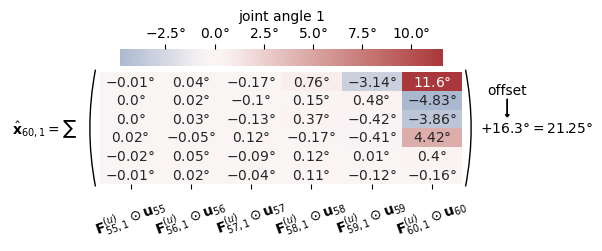

In [71]:
result_directory = pathlib.Path.cwd().parent.joinpath('results').joinpath('industrial-robot')
model_explainer_names = [
    ('LSTM+Init-192-2', 'LIME'),
    ('ReLiNet-256-4', 'ReLiNet-Explainer'),
    ('StableReLiNet-128-4', 'ReLiNet-Explainer')
]
sample_idx = 0
target_idx = 0

def plot_explanation(
    result_directory: pathlib.Path,
    model_name: str,
    explainer_name: str,
    sample_idx: int,
    target_idx: int,
    threshold: float = 1e-2,
    annotation_rounding: int = 2
) -> None:
    loader = ExplanationLoader(
        model_name=model_name,
        explainer_name=explainer_name,
        result_directory=result_directory,
        window_size=60,
        horizon_size=60
    )
    explanation, model_input = loader.load_explanation(sample_idx)

    contribution_initial_state = explanation.weights_initial_state * model_input.initial_state[np.newaxis, :, :]
    contribution_initial_control = explanation.weights_initial_control * model_input.initial_control[np.newaxis, :, :]
    contribution_control = explanation.weights_control * model_input.control[np.newaxis, :, :]
    contribution_intercept = explanation.intercept

    contribution_initial_state = contribution_initial_state[target_idx, :, :]
    contribution_initial_control = contribution_initial_control[target_idx, :, :]
    contribution_control = contribution_control[target_idx, :, :]
    contribution_intercept = contribution_intercept[target_idx]

    # Identify earliest relevant plottable contribution.
    heatmap = np.vstack((
        contribution_initial_state,
        contribution_initial_control,
        contribution_control
    ))
    heatmap = heatmap.T
    earliest_relevant_step = np.min(np.argmax(heatmap > threshold, axis=1))
    heatmap = heatmap[:, earliest_relevant_step:]

    if earliest_relevant_step < 120:
        raise NotImplementedError(
            'Initial state or control had impact on prediction. '
            'We have not implemented the visualization for this case.'
        )


    x_right = heatmap.shape[0] - 1.0
    x_left = 0.0
    y_top= heatmap.shape[1]
    y_bottom = 1.0

    time_steps = [
        earliest_relevant_step + idx - 119
        for idx in range(heatmap.shape[0])
    ]

    fig, ax = plt.subplots(
        1, 3,
        width_ratios=[1, 4, 1],
        sharex=True,
        sharey=True,
        figsize=(FIGURE_WIDTH, FIGURE_HEIGHT)
    )
    fig.subplots_adjust(wspace=0, hspace=0)

    ax[0].axis('off')
    ax[0].annotate(
        '',
        xy=(x_right + 0.7, y_bottom - 0.2), xycoords='data',
        xytext=(x_right + 0.7, y_top + 0.2), textcoords='data',
        arrowprops={
            'connectionstyle': 'arc3,rad=-0.1',
            'arrowstyle': '-'
        }
    )
    ax[0].text(
        x_left + 0.1,
        (y_top - y_bottom) * 0.5 + y_bottom,
        r'$\hat{\mathbf{x}}_{' + f'{time_steps[-1]},{target_idx+1}' + '} = \sum$',
        va='center'
    )

    annot = np.vectorize(
        lambda i: '$' + str(i) + r'\degree$'
    )(np.round(heatmap, annotation_rounding))

    xticklabels = [
        r'$\mathbf{F}^{(u)}_{' + f'{step},{target_idx+1}' + r'}\odot\mathbf{u}_{' + f'{step}' + '}$'
        for step in time_steps
    ]
    sns.heatmap(
        data=heatmap,
        cmap='vlag',
        center=0.0,
        annot=annot,
        xticklabels=xticklabels,
        fmt='',
        cbar_kws={
            'location': 'top',
            'fraction': 0.12,
            'format': r'${x}\degree$',
            'label': f'joint angle {target_idx + 1}'
        },
        ax=ax[1]
    )
    ax[1].tick_params(axis='x', rotation=20)
    ax[1].get_yaxis().set_visible(False)

    ax[2].axis('off')
    ax[2].text(
        (x_right - x_left) * .7/3 + x_left,
        (y_top - y_bottom) * 0.5 + y_bottom,
        f'$+{np.round(contribution_intercept, 2)}' + r'\degree' + f'={np.round(contribution_intercept + np.sum(heatmap), 2)}' + r'\degree$',
        va='center'
    )
    ax[2].annotate(
        '',
        xy=(x_left + 0.2, y_bottom - 0.2), xycoords='data',
        xytext=(x_left + 0.2, y_top + 0.2), textcoords='data',
        arrowprops={
            'connectionstyle': 'arc3,rad=0.1',
            'arrowstyle': '-'
        },
        color='black'
    )
    ax[2].text(
        (x_right - x_left) * 1.0/3 + x_left,
        (y_top - y_bottom) * 0.5 + y_bottom - 1.5,
        'offset'
    )
    ax[2].arrow(
        (x_right - x_left) * 0.6 + x_left,
        (y_top - y_bottom) * 0.5 + y_bottom - 1.3,
        0.0,
        0.7,
        width=0.001,
        head_width=250*0.001,
        head_length=100*0.001,
        color='black'
    )
    
    plt.savefig(f'{model_name}-{explainer_name}.pdf', bbox_inches='tight', pad_inches=0)

plot_explanation(
    result_directory=result_directory,
    model_name=model_explainer_names[1][0],
    explainer_name=model_explainer_names[1][1],
    sample_idx=sample_idx,
    target_idx=target_idx
)

In [62]:
plot_explanation(
    result_directory=result_directory,
    model_name=model_explainer_names[0][0],
    explainer_name=model_explainer_names[0][1],
    sample_idx=sample_idx,
    target_idx=target_idx,
    threshold=1e-2,
    annotation_rounding=2
)

NotImplementedError: Initial state or control had impact on prediction. We have not implemented the visualization for this case.